# Zestaw 9. Page Rank

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## 1. Prosty ranking wierzchołków

<i>Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym.</i>

#### generowanie grafów spójnych

In [4]:
def get_connected_graph(n):
    graph = nx.generators.directed.random_k_out_graph(n, n-2, 3)
    nodes = max(nx.strongly_connected_components(graph), key=len)
    connected_graph = nx.DiGraph()
    for node in nodes:
        for edge in graph.out_edges(node):
            connected_graph.add_edge(*edge)
    return connected_graph

In [5]:
def draw_graph(graph, pos):
    plt.figure(figsize=(10, 5))
    labels = {n: graph.nodes[n].get('weight', ' ') for n in graph.nodes}
    nx.draw(graph, pos=pos, with_labels=True, labels=labels, node_color='thistle', edge_color='silver')

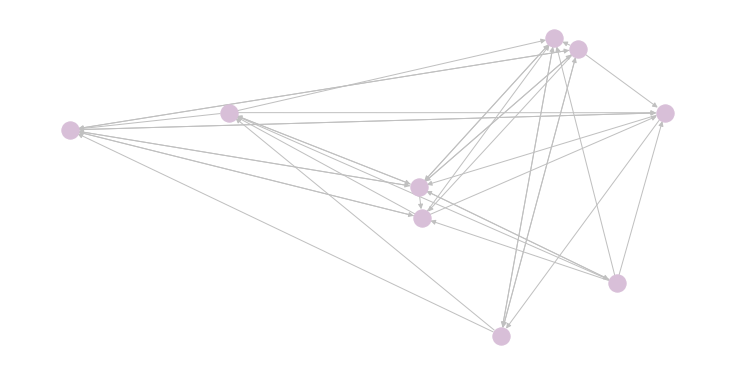

In [6]:
graph = get_connected_graph(10)
print(graph)
pos = nx.random_layout(graph)
draw_graph(graph, pos)

#### metoda potęgowa

In [7]:
def power_method(A, epsilon=1e-8, max_iteration=100):
    def norm_inf(x): return np.linalg.norm(x, np.inf)
    def normalize(x): return x/np.linalg.norm(x, ord=1)
    
    n = A.shape[0]
    prev_x = np.ones(n)
    x = A @ prev_x
    
    max_x = norm_inf(x)
    x /= max_x
    iteration = 1
    
    while iteration < max_iteration and not np.allclose(x, prev_x, atol=epsilon) and not np.allclose(x, -prev_x, atol=epsilon):
        x, prev_x = A @ x, x
        max_x = norm_inf(x)
        x /= max_x
        iteration += 1
        
    return normalize(x)

#### ranking

<i>Zaimplementuj prosty model błądzenia przypadkowego po grafie skierowanym</i>

In [8]:
def simple_rank(graph, d=1):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes())
    A = np.zeros((n, n))
    
    for u in range(n):
        for v in range(n):
            if (nodes[u], nodes[v]) in graph.edges():
                A[u][v] = 1/len(graph.out_edges(nodes[u]))
                
    r = power_method(d*A.T)
    
    for u in range(n):
        graph.nodes[nodes[u]]['weight'] = round(r[u], 3)
        
    return graph, r

In [9]:
graph, rank = simple_rank(graph)

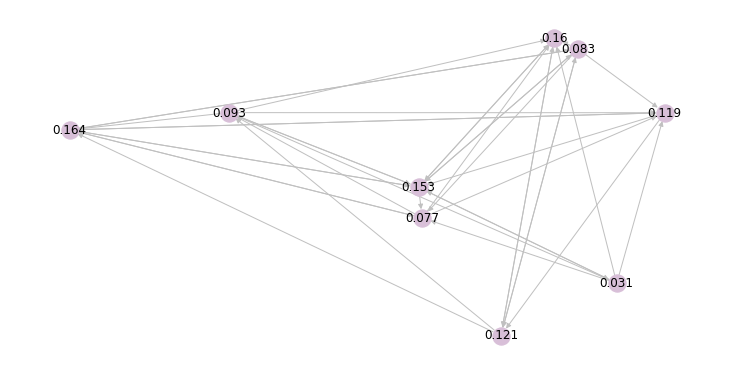

In [10]:
draw_graph(graph, pos)

#### testy

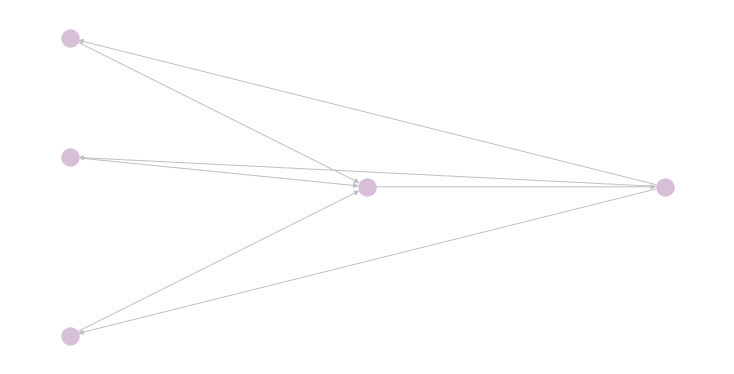

In [14]:
simple_graph = nx.DiGraph()
simple_graph.add_edge(0, 3)
simple_graph.add_edge(1, 3)
simple_graph.add_edge(2, 3)
simple_graph.add_edge(3, 4)
simple_graph.add_edge(4, 0)
simple_graph.add_edge(4, 1)
simple_graph.add_edge(4, 2)

pos = {0: (0, 0), 1: (0, 1.2), 2: (0, 2), 3: (1, 1), 4: (2, 1)}

draw_graph(simple_graph, pos)

Testy rozpoczynam od prostego grafu, na którym łatwo można prześledzić charakterystykę połączeń. Z wierzchołków o numerach 0, 1, 2 prowadzą krawędzie do wierzchołka nr 3. Wierzhołek nr 3 wskazuje na ten o numerze 4, który z kolei wskazuje na wierzchołki 0, 1 i 2. Spodziewamy się, iż najwyższa wartość w rankingu będzie dla wierzchołka nr 3, jako iż wchodzą do niego 3 krawędzie, a wychodzi tylko jedna.

rank:  [0.06666667 0.6        0.06666667 0.06666667 0.2       ]


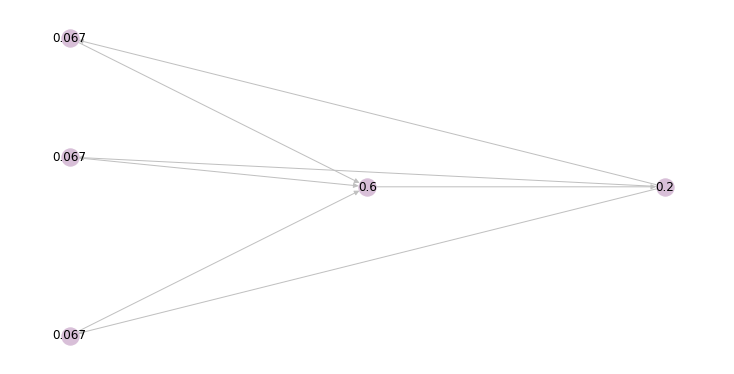

In [16]:
ranked_simple_graph, rank_ = simple_rank(simple_graph)
print('rank: ', rank_)
draw_graph(simple_graph, pos)

Zgodnie z oczekiwaniami największa wartość przyporządkowana została wierzchołkowi nr 3.  Stosunkową dużą wartością w rankingu cechuje się wierzchołek nr 4; mimo że wskazuje na niego tylko jeden wierzchołek, a on sam wskazuje na aż 3, to wskazujący na niego element ma powiązaną dużą wartość, co zwiększa rangę wierzchołka nr 4.

Następnie generuję losowe spójne grafy i szukam dla nich ranking wierzchołków:

rank:  [0.06021908 0.17478514 0.12523605 0.13974509 0.1401271  0.0783716
 0.07706984 0.16948896 0.02913092 0.00582623]


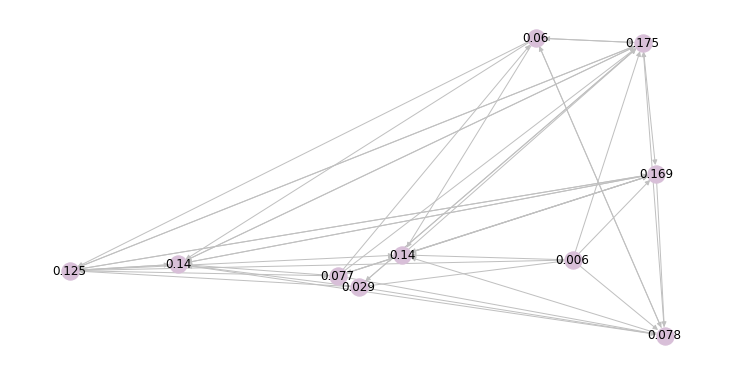

In [17]:
graph1 = get_connected_graph(11)
ranked_graph1, rank1 = simple_rank(graph1)
print('rank: ', rank1)
draw_graph(ranked_graph1, nx.random_layout(ranked_graph1))

rank:  [0.07710941 0.06974571 0.06182737 0.03508636 0.06541851 0.08924136
 0.02295918 0.02505303 0.04886559 0.06105916 0.02034138 0.05157292
 0.06159197 0.06095782 0.05919889 0.05488524 0.06193324 0.03790369
 0.02056738 0.01468178]


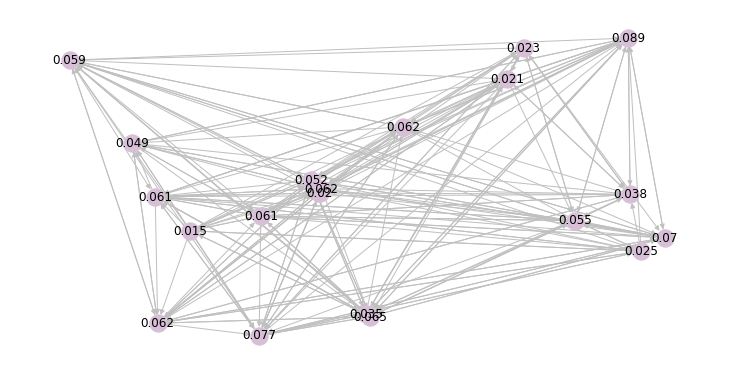

In [18]:
graph2 = get_connected_graph(20)
ranked_graph2, rank2 = simple_rank(graph2)
print('rank: ', rank2)
draw_graph(ranked_graph2, nx.random_layout(ranked_graph2))

rank:  [0.00813596 0.03166935 0.0234326  0.02822795 0.01698022 0.01501934
 0.02971853 0.0217847  0.02166035 0.02034077 0.03090193 0.02156972
 0.02961753 0.02253155 0.0161916  0.01049785 0.01722974 0.02441339
 0.01165599 0.02827727 0.03234353 0.02703937 0.03182539 0.00974082
 0.01399942 0.02832545 0.02073883 0.02756869 0.01525027 0.01890121
 0.03180631 0.0132675  0.02057604 0.01653412 0.012648   0.0229359
 0.02084305 0.0082376  0.02537096 0.02610486 0.01126832 0.01566547
 0.01557934 0.01418424 0.02151558 0.02211751 0.00737884 0.01152178
 0.01855932 0.00829597]


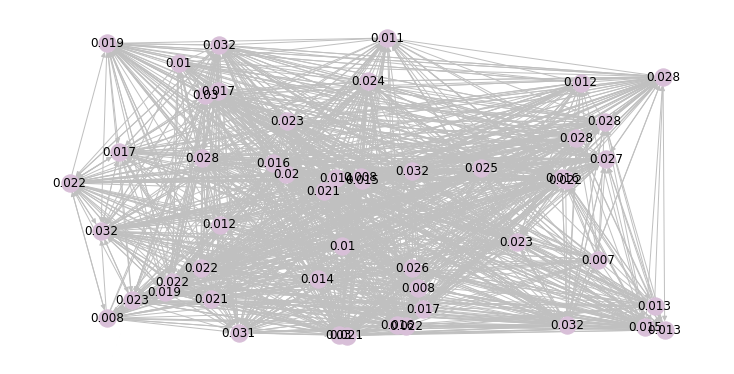

In [19]:
graph3 = get_connected_graph(50)
ranked_graph3, rank3 = simple_rank(graph3)
print('rank: ', rank3)
draw_graph(ranked_graph3, nx.random_layout(ranked_graph3))

W powyższych przypadkach wygenerowane grafy są prawie że grafami pełnymi, a w związku z tym wartości w rankingu są do siebie zbliżone, żaden wierzchołek nie dominuje.

## 2. Page Rank

In [20]:
def page_rank(graph, d, e, add_labels=False):
    n = graph.number_of_nodes()
    nodes = list(graph.nodes())
    A = np.zeros((n, n))
    
    for u in range(n):
        for v in range(n):
            if (nodes[u], nodes[v]) in graph.edges():
                A[u][v] = 1/len(graph.out_edges(nodes[u]))
    
    
    B = d*A + (1-d)*e
    
    r = power_method(B.T)
    
    if add_labels:
        for i in range(n):
            graph.nodes[nodes[i]]['weight'] = round(r[i], 3)
    
    return graph, {nodes[i]: round(r[i], 3) for i in range(n)}

In [21]:
def nx_page_rank(graph, d, e):
    nodes = list(graph.nodes())
    personalization = {nodes[i]: e[i] for i in range(graph.number_of_nodes())}
    rank = nx.algorithms.link_analysis.pagerank_alg.pagerank(graph, alpha=d, personalization=personalization)
    return {key: round(rank[key], 3) for key in rank}

## Testy

#### przykładowy graf

Najpierw przeprowadzam testy dla proste grafu z poprzedniej części.

rank:  {0: 0.067, 3: 0.6, 1: 0.067, 2: 0.067, 4: 0.2}


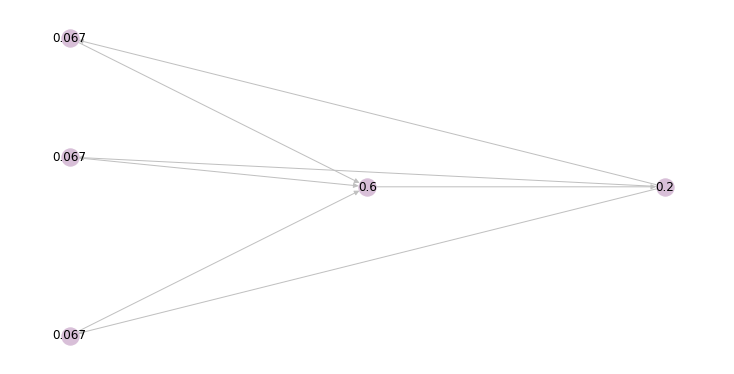

In [25]:
ranked_simple_graph, rank_ = page_rank(simple_graph, 1, np.ones(len(simple_graph))/len(simple_graph), True)
print('rank: ', rank_)
draw_graph(ranked_simple_graph, pos)

Możemy zauważyć, że dla d=1 i wektora e o rozkładzie jednopunktowym, wynik jest tożsamy z tym otrzymanym dla prostego rankingu wierzchołków w punkcie 1.

rank:  {0: 0.118, 3: 0.332, 1: 0.118, 2: 0.118, 4: 0.312}


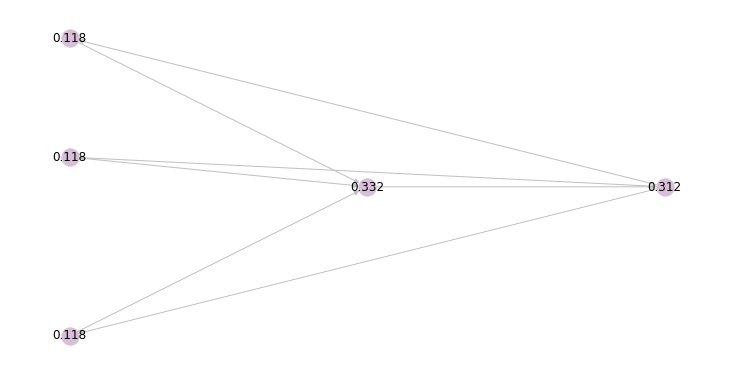

In [24]:
ranked_simple_graph, rank_ = page_rank(simple_graph, 0.85, np.ones(len(simple_graph))/len(simple_graph), True)
print('rank: ', rank_)
draw_graph(ranked_simple_graph, pos)

Przez zmianę współczynnika d wpłynęliśmy na wartości w rankingu, jednak kolejność wierzchołków w rankingu nie uległa zmianie.

rank:  {0: 0.23, 3: 0.33, 1: 0.08, 2: 0.08, 4: 0.281}


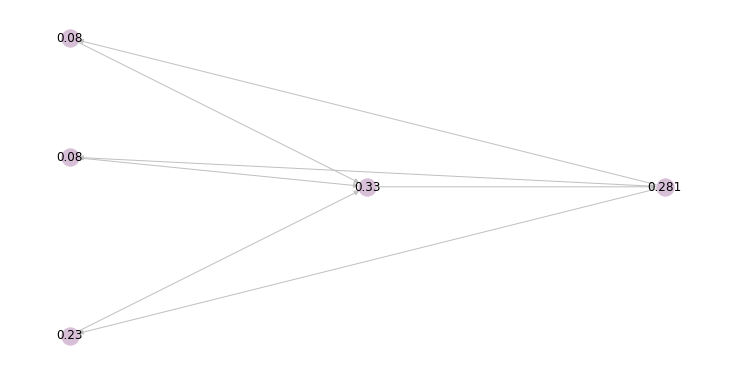

In [18]:
e = np.zeros(len(graph4))
e[0] = 1
ranked_graph4, rank4 = page_rank(graph4, 0.85, e, True)
print('rank: ', rank4)
draw_graph(ranked_graph4, pos)

W powyższym przykładzie dobrany wektor e wprowadził do układu duże prawdopodobieństwo przeskoku do wierzchołka nr 0. Dzięki temu wartość tegoż wierzchołka bardzo wzrosłą w stosunku do wcześniej nierozróżnialnych z nim wierzchołków 1 i 2.

Następnie, dokonuję testów dla losowych grafów silnie spójnych, porównując wyniki z wartościami otrzymanymi przy użyciu funkcji z biblioteki networkx.

In [26]:
def test_page_rank(graph, e=None, d=0.85, print_highest=False):
    if e is None:
        n = graph.number_of_nodes()
        e = np.ones(n)/n
        
    graph, rank = page_rank(graph, d, e)
    
    if print_highest:
        print(sorted(rank.items(), key=lambda x:x[1], reverse=True)[:10])
        return

    print('e: ', e)
    print('rank: ', rank)
    print('nx rank: ', nx_page_rank(graph, d, e))
    print('max rank: ', max(rank.items(), key=lambda x: x[1]))

#### dla różnych wektorów e

dla e o rozkładzie jednopunktowym

In [27]:
n = graph.number_of_nodes()
test_page_rank(graph, np.ones(n)/n)

e:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
rank:  {0: 0.121, 7: 0.155, 6: 0.147, 8: 0.117, 1: 0.044, 5: 0.082, 4: 0.153, 3: 0.098, 9: 0.084}
nx rank:  {0: 0.121, 7: 0.155, 6: 0.147, 8: 0.117, 1: 0.044, 5: 0.082, 4: 0.153, 3: 0.098, 9: 0.084}
max rank:  (7, 0.155)


wektor e z przewagą wartości dla jednego z wierzchołków

In [28]:
n = graph.number_of_nodes()
e = np.zeros(n)
e[0] = 1

test_page_rank(graph, e)

e:  [1. 0. 0. 0. 0. 0. 0. 0. 0.]
rank:  {0: 0.27, 7: 0.156, 6: 0.138, 8: 0.116, 1: 0.023, 5: 0.059, 4: 0.105, 3: 0.066, 9: 0.066}
nx rank:  {0: 0.27, 7: 0.156, 6: 0.138, 8: 0.116, 1: 0.023, 5: 0.059, 4: 0.105, 3: 0.066, 9: 0.066}
max rank:  (0, 0.27)


Wektor e reprezentuje prawdopodobieństwo odwiedzenia wierzchołków przez losowy skok. Dzięki niemu jesteśmy w stanie uwzględnić znane preferencje w rankingu i chociażby spersonalizować wynik wyszukiwania, pod względem interesujących kategorii.

#### dla różnych wartości d

In [29]:
test_page_rank(graph, d=0.9)

e:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
rank:  {0: 0.12, 7: 0.158, 6: 0.149, 8: 0.119, 1: 0.039, 5: 0.08, 4: 0.155, 3: 0.096, 9: 0.083}
nx rank:  {0: 0.12, 7: 0.158, 6: 0.149, 8: 0.119, 1: 0.039, 5: 0.08, 4: 0.155, 3: 0.096, 9: 0.083}
max rank:  (7, 0.158)


In [30]:
test_page_rank(graph, d=0.85)

e:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
rank:  {0: 0.121, 7: 0.155, 6: 0.147, 8: 0.117, 1: 0.044, 5: 0.082, 4: 0.153, 3: 0.098, 9: 0.084}
nx rank:  {0: 0.121, 7: 0.155, 6: 0.147, 8: 0.117, 1: 0.044, 5: 0.082, 4: 0.153, 3: 0.098, 9: 0.084}
max rank:  (7, 0.155)


In [31]:
test_page_rank(graph, d=0.75)

e:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
rank:  {0: 0.121, 7: 0.15, 6: 0.142, 8: 0.116, 1: 0.052, 5: 0.085, 4: 0.148, 3: 0.1, 9: 0.085}
nx rank:  {0: 0.121, 7: 0.15, 6: 0.142, 8: 0.116, 1: 0.052, 5: 0.085, 4: 0.148, 3: 0.1, 9: 0.085}
max rank:  (7, 0.15)


In [32]:
test_page_rank(graph, d=0.6)

e:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
rank:  {0: 0.121, 7: 0.142, 6: 0.136, 8: 0.113, 1: 0.064, 5: 0.09, 4: 0.141, 3: 0.104, 9: 0.089}
nx rank:  {0: 0.121, 7: 0.142, 6: 0.136, 8: 0.113, 1: 0.064, 5: 0.09, 4: 0.141, 3: 0.104, 9: 0.089}
max rank:  (7, 0.142)


In [33]:
test_page_rank(graph, d=0.5)

e:  [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
rank:  {0: 0.12, 7: 0.136, 6: 0.131, 8: 0.112, 1: 0.073, 5: 0.094, 4: 0.136, 3: 0.106, 9: 0.091}
nx rank:  {0: 0.12, 7: 0.136, 6: 0.131, 8: 0.112, 1: 0.073, 5: 0.094, 4: 0.136, 3: 0.106, 9: 0.091}
max rank:  (7, 0.136)


#### graf z bazy Snap

In [36]:
def graph_from_file(file_name):
    graph = nx.DiGraph()
    with open(file_name, 'r') as f:
        next(f)
        for line in f:
            if line[0] == '#': continue
            u, v = line.split('\t')[:2]
            u = u.strip()
            v = v.strip()
            graph.add_edge(u, v)
    return graph

Testuję działanie funkcji dla danych z bazy Snap. Poniższy plik zawiera informacje o hiperlinkach z jednego subforum do innego na portalu Reddit.

In [ ]:
graph_reddit = graph_from_file('soc-redditHyperlinks-body.tsv')

In [ ]:
test_page_rank(graph_reddit, print_highest=True)

Subreddit o najwyższej wartości w rankingu to 'IAmA'. Ma to sens, zważywszy na fakt, że ma on 21M członków, stworzono go w roku 2009.

## Wnioski

 - Dzięki dekompozycji spektralnej często jesteśmy w stanie rozwiązać problem określony zależnością niejawną/uwikłaną.
 - Przez wprowadzenie wektora e i d możemy modelować zagadnienie tak, aby dobrze reprezentowało specyfikę problemu.

M. Hawryluk 23.05.2021